In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


In [55]:

# Define the transformation to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1)),
    #transforms.Lambda(lambda x: x/255.0),
])


In [56]:
# Load the training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Filter out images for digits 1 and 9
idx_1 = train_dataset.targets == 1
idx_9 = train_dataset.targets == 9
idx = idx_1 | idx_9
train_dataset.targets = train_dataset.targets[idx]
train_dataset.data = train_dataset.data[idx]

# Load the test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Filter out images for digits 1 and 9
idx_1 = test_dataset.targets == 1
idx_9 = test_dataset.targets == 9
idx = idx_1 | idx_9
test_dataset.targets = test_dataset.targets[idx]
test_dataset.data = test_dataset.data[idx]

train_dataset.targets = torch.where(train_dataset.targets == 1, torch.tensor(1), torch.tensor(0))
test_dataset.targets = torch.where(test_dataset.targets == 1, torch.tensor(1), torch.tensor(0))

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)



In [57]:
test_dataset.data.max(), test_dataset.data.min()

(tensor(255, dtype=torch.uint8), tensor(0, dtype=torch.uint8))

In [58]:
for images, labels in train_loader:
    # Print the shape of the data
    print("Shape of images:", images.shape)
    print("Shape of labels:", labels.shape)
    break  # Exit the loop after the first batch

Shape of images: torch.Size([64, 784])
Shape of labels: torch.Size([64])


In [59]:
images.max(),images.min()

(tensor(1.), tensor(0.))

In [60]:
train_dataset.targets.sum()/ len(train_dataset.targets)

tensor(0.5312)

In [61]:
test_dataset.targets

tensor([1, 1, 0,  ..., 1, 0, 1])

In [63]:
# Define the MLP model
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)  # 10 output classes for digits 0-9

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return torch.sigmoid(x)

# Create an instance of the model
model = MLP()
model.to(device)
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)



In [98]:
# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data)
        # Calculate loss
        loss = criterion(outputs.flatten(), targets.type(torch.float))
        total_loss += loss.item()
        # Calculate accuracy
        predicted = outputs.int().flatten()
        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()

        #if batch_idx % 100 == 0:
            #print(f'Epoch {epoch+1}/{num_epochs}, Step {batch_idx}/{len(train_loader)}, Loss: {loss.item()}')

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = total_correct / total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {epoch_acc}')


Epoch 1/30, Loss: 5.7714584730440256e-08, Accuracy: 0.9991332440312032
Epoch 2/30, Loss: 5.087529689270019e-08, Accuracy: 0.9991332440312032
Epoch 3/30, Loss: 4.481449414395199e-08, Accuracy: 0.9991332440312032
Epoch 4/30, Loss: 3.932458813378552e-08, Accuracy: 0.9991332440312032
Epoch 5/30, Loss: 3.3889907962380724e-08, Accuracy: 0.9991332440312032
Epoch 6/30, Loss: 2.9243880812163796e-08, Accuracy: 0.9991332440312032
Epoch 7/30, Loss: 2.529993991953403e-08, Accuracy: 0.9991332440312032
Epoch 8/30, Loss: 2.2078260238774877e-08, Accuracy: 0.9991332440312032
Epoch 9/30, Loss: 1.9067888173897793e-08, Accuracy: 0.9991332440312032
Epoch 10/30, Loss: 1.6451158016072983e-08, Accuracy: 0.9992908360255299
Epoch 11/30, Loss: 1.4314203501939266e-08, Accuracy: 0.9992908360255299
Epoch 12/30, Loss: 1.2460824324430763e-08, Accuracy: 0.9993696320226932
Epoch 13/30, Loss: 1.0843256403168036e-08, Accuracy: 0.9993696320226932
Epoch 14/30, Loss: 9.495342448375848e-09, Accuracy: 0.9994484280198566
Epoch 

In [99]:
# Evaluate the model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        predicted = outputs.int().flatten()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
        #correct += (predicted == targets).sum().item()

print(f'Accuracy on the test set: {correct/total}')

Accuracy on the test set: 0.9976679104477612


In [189]:
from torch.utils.data import DataLoader


def fgsm_attack(image, epsilon, data_grad):
    """
    Function to perform the fast gradient sign method (FGSM) attack.
    :param image: input image
    :param epsilon: small constant for perturbation
    :param data_grad: gradient of the data
    :return: perturbed image
    """
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [195]:

def test_model_with_fgsm(model, device, test_loader, epsilon):
    """
    Function to test the model using adversarial examples created with FGSM.
    :param model: the neural network
    :param device: device to perform computation
    :param test_loader: data loader for the test set
    :param epsilon: epsilon for FGSM attack
    """
    correct = 0
    adv_examples = []
    model.eval()  # Ensure the model is in evaluation mode
    criterion = nn.BCELoss()  # Initialize BCE Loss

    # Loop over all examples in the test set
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        target = target.float()  # Ensure target is float
        data.requires_grad = True  # Enable gradient computation for the data

        # Forward pass
        output = model(data)




        # Make sure the output and target have the same dimensions
        if output.dim() == 2 and output.shape[1] == 1:
            target = target.unsqueeze(1)
            print("target")
            print(target.shape)
            break



        loss = criterion(output.flatten(), target)  # Calculate the binary cross entropy loss

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of the model in the backward pass
        loss.backward()

        # Check if gradients are available
        if data.grad is not None:
            data_grad = data.grad.data
            perturbed_data = fgsm_attack(data, epsilon, data_grad)
            #print(f"PD: {perturbed_data.shape }")
        else:
            print("Gradient not available, skipping adversarial example generation.")
            continue  # Skip the rest of this loop iteration if gradients are not available

        # Re-classify the perturbed data
        output = model(perturbed_data)
        #print(f"OO: {output.shape}")
        final_pred =  output.int().flatten() #binarizing it


        # Update the correct count
        #print(final_pred)
        #print(target)
        correct += (final_pred == target).sum().item()  # Ensure dimension match for comparison
        #print(f"before{perturbed_data}")
        # Collect adversarial examples for visualization if needed
        if len(adv_examples) < 5:
            #print(f"before adv_ex {adv_ex}")
            #adv_ex1 = perturbed_data[0].squeeze().detach().cpu().numpy()
            #print(f"after adv_ex {adv_ex}")
            adv_ex = perturbed_data[0].detach().cpu().numpy()

            #adv_examples.append((output[0].item(), final_pred[0].item(), adv_ex))
            adv_examples.append((target[0].item(), final_pred[0].item(), adv_ex))
            #print(perturbed_data)
            #print(adv_examples)

    # Calculate the final accuracy
    final_acc = correct / float(len(test_loader.dataset))
    print(f'Epsilon: {epsilon}, Test Accuracy = {final_acc * 100:.2f}%')

    return final_acc, adv_examples


In [196]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()  # Set the model in evaluation mode

# Example of testing the model with an epsilon value
epsilon = 0.9  # Small enough to be imperceptible, large enough to cause misclassification
test_accuracy, adversarial_examples = test_model_with_fgsm(model, device, test_loader, epsilon)


AttributeError: 'ellipsis' object has no attribute 'eval'

In [180]:
y_true, y_pred, adv_image = adversarial_examples[0]
y_true, y_pred

(1.0, 1)

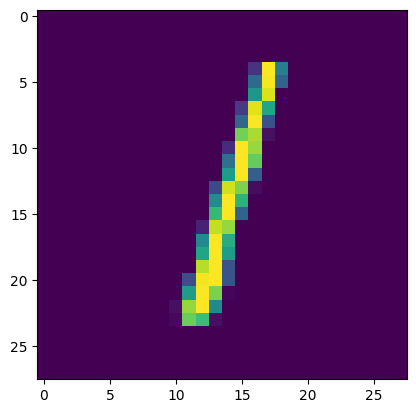

In [181]:
import matplotlib.pyplot as plt

plt.imshow(adv_image.reshape(28,28));